<a href="https://colab.research.google.com/github/ravellys/PID-1/blob/master/Remo%C3%A7%C3%A3o_de_Ru%C3%ADdos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importando libs

In [7]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm
import os
import imageio

%matplotlib inline

In [8]:
from google.colab import drive 
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Funções básicas

In [3]:
def import_file(path):
  list_files = os.listdir(path) # lista de arquivos dentro da pasta das amostras
  list_files = np.sort(np.array(list_files)) # organizar os arquivos
  im = [] # inicialização do vetor de armazenamento

  for file in tqdm(list_files) :
    fetch_file = os.path.join(path, file)  
    image = np.array(imageio.imread(fetch_file)) # importa imagem e converte em numpy
 
    im.append(image.T) # Adiciona matriz numpy ao vetor de armazenameto

  im = np.array(im)
  return im 

In [139]:
#altera range dos tons de cinza
def im_alt_range(im, n_min=0, n_max=255):
  min = im.min()
  max = im.max()
  im_ = n_min +(im - min)*(n_max - n_min)/(max - min)
  return im_.astype(int)

In [140]:
def im_recort(im,x,y,z):
  x_size,y_size,z_size = im.shape
  s_x,s_y,s_z = np.array([(x_size-x)/2,(y_size-y)/2,(z_size-z)/2]).astype(int)
  e_x,e_y,e_z = np.array([x_size-(x_size-x)/2,y_size-(y_size-y)/2,z_size-(z_size-z)/2]).astype(int)

  return im[s_x:e_x,s_y:e_y,s_z:e_z] # separa uma região de 400x400x400

In [141]:
# Plota imagem e secção horizontal
def im_sec_plot(img, pos=100, bits=8):
  leny,lenx = img.shape
  line = img[pos,:]

  x = np.linspace(0,len(line),len(line))
  fig,ax = plt.subplots(ncols=2, figsize = (15,7))
  ax = ax.ravel()

  ax[0].plot(x,line)
  ax[0].grid()

  ax[1].imshow(img,"gray", vmin =  0, vmax = 2**bits)
  ax[1].hlines(pos, 0, lenx,color = 'red')
  ax[1].set_xlim(0, lenx)

  plt.show()  

# Importando dados

In [298]:
# importar dataset 
path = 'drive/My Drive/Artigo Segmentação/Imagens/Tambaba' #pasta da amostra
im = import_file(path)
im = im_recort(im,650,300,300)
print(im.shape)

100%|██████████| 761/761 [00:06<00:00, 114.97it/s]


(650, 300, 300)


In [299]:
im = im_alt_range(im/2**16, n_min=0, n_max=255)

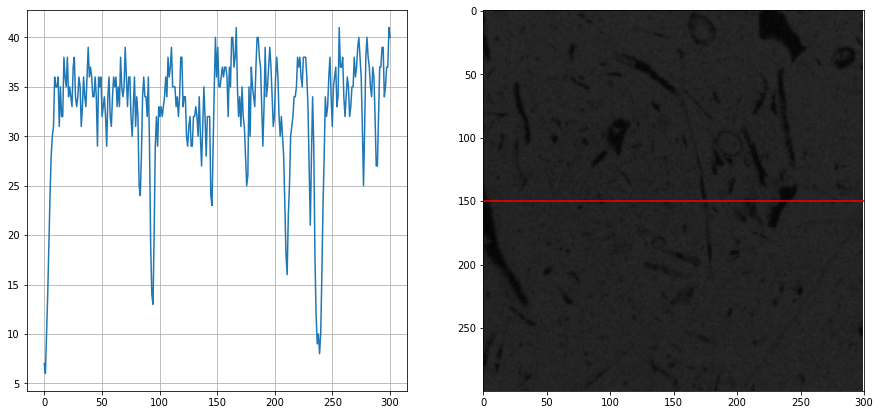

In [300]:
im_sec_plot(im[0], pos=150, bits=8)

# Mediana

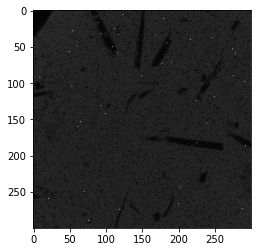

In [301]:
from skimage import util

kwargs = {'amount':.05, 'salt_vs_pepper': 0.01}

im_noise = []
for img in im:
  noisy_image = util.random_noise(img/255, seed=0, mode= 's&p', **kwargs)
  im_noise.append(noisy_image)

im_noise = np.array(im_noise)  
plt.imshow(im_noise[454], cmap = 'gray')

In [302]:
# Aplicação de FIltro de Média
from skimage.morphology import disk, square, cube
from skimage.filters import rank

# tamanhos das mascaras para 
selem = square(3)
im_denoise = []
for im_n in im_noise:
  im_normal = rank.median(im_n, selem=selem)
  im_denoise.append(im_normal)
im_denoise = np.array(im_denoise)

/usr/local/lib/python3.6/dist-packages/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)


Imagm com ruído


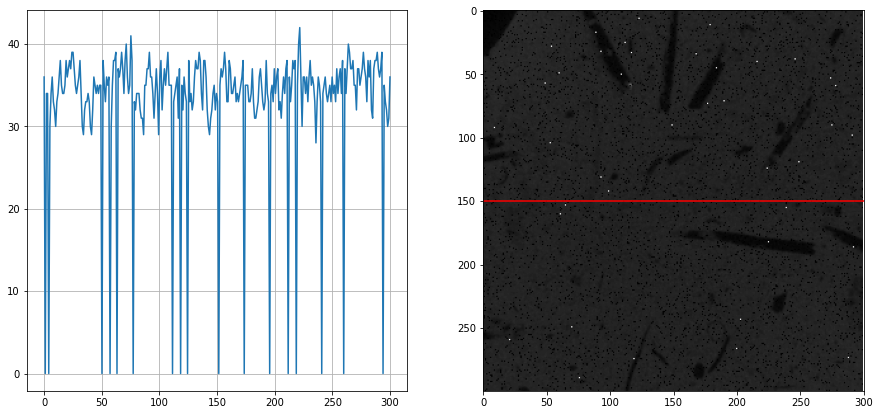

Filtro de mediana


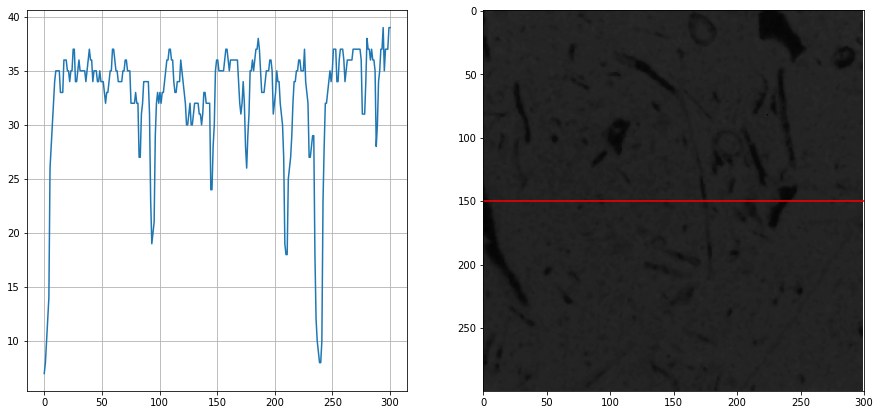

In [303]:
print(f"Imagm com ruído")
im_sec_plot(255*im_noise[454], pos=150, bits=8)

print(f"Filtro de mediana")
im_sec_plot(im_denoise[0], pos=150, bits=8)

In [306]:
from matplotlib import image
from PIL import Image


path_out = 'drive/My Drive/Artigo Segmentação/Imagens/out_tambaba/denoise_mediana/'

for i, img in enumerate(im_denoise):
  img = Image.fromarray(img)
  img.save(path_out + f'im_{i}.tif')
  #image.imsave(path_out + f'im_{i}.tiff', im, cmap='gray')

# Bilateral

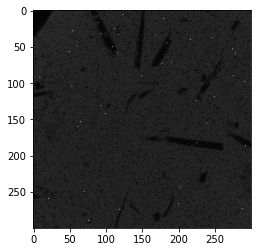

In [273]:
from skimage import util

kwargs = {'amount':.05, 'salt_vs_pepper': 0.01}

im_noise = []
for img in im:
  noisy_image = util.random_noise(img/255, seed=0, mode='s&p', **kwargs)
  im_noise.append(noisy_image)

im_noise = np.array(im_noise)  
plt.imshow(im_noise[454], cmap = 'gray')

Imagm com ruído


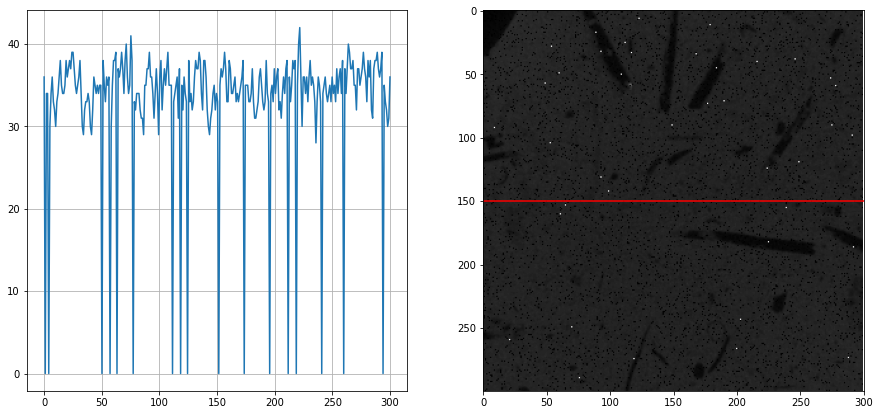

Filtro de denoise_bilateral


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: The last axis of the input image is interpreted as channels. Input image with shape (650, 300, 300) has 300 channels in last axis. ``denoise_bilateral`` is implemented for 2D grayscale and color images only
  


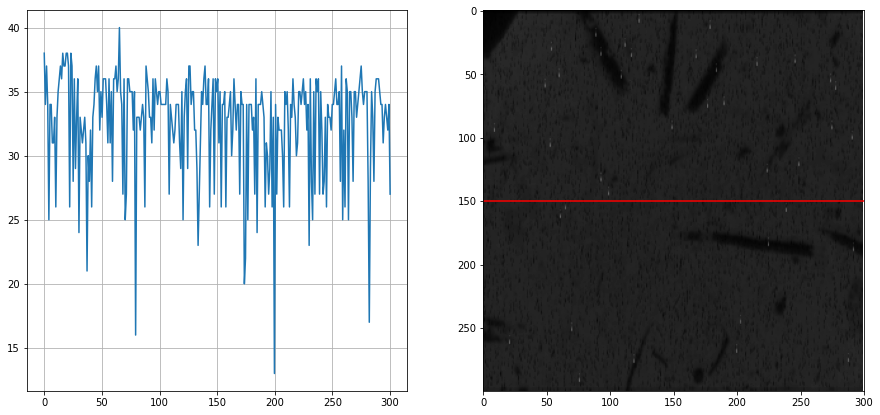

In [274]:
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)

print(f"Imagm com ruído")
im_sec_plot(255*im_noise[454], pos=150, bits=8)

print(f"Filtro de denoise_bilateral")
im_denoise = (255*denoise_bilateral(im_noise, sigma_color=1, multichannel=True)).astype(int)
im_sec_plot(im_denoise[454], pos=150, bits=8)

In [275]:
from matplotlib import image
path_out = 'drive/My Drive/Artigo Segmentação/Imagens/out_tambaba/denoise_bilateral/'

for i, im in enumerate(im_denoise):
  image.imsave(path_out + f'im_{i}.tiff', im, cmap='gray')

# Deep Learning

In [282]:
# separar amostra de treino e teste
LIM_TREINO = int(.7*im.shape[0])
X_train, X_test  = im[:LIM_TREINO], im[LIM_TREINO:]

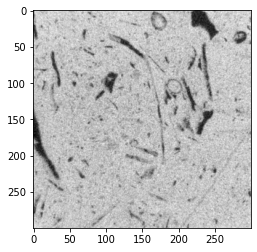

In [283]:
# Visualize a sample image
plt.imshow(X_train[0], cmap = 'gray')

In [284]:
# check out the shape of the training data
X_train.shape

(454, 300, 300)

In [285]:
# check out the shape of the testing data
X_test.shape

(196, 300, 300)

## Pre processamento de dados

In [286]:
# normalize data
X_train = X_train/255
X_test = X_test/255

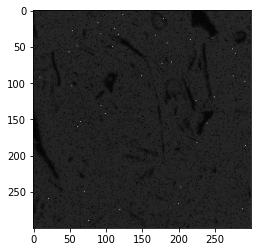

In [287]:
from skimage import util

kwargs = {'amount':.05, 'salt_vs_pepper': 0.01}

noise_dataset = []
for img in X_train:
  noisy_image = util.random_noise(img, seed=0, mode= 's&p', **kwargs)
  noise_dataset.append(noisy_image)

noise_dataset = np.array(noise_dataset)  
plt.imshow(noise_dataset[0], cmap = 'gray') 

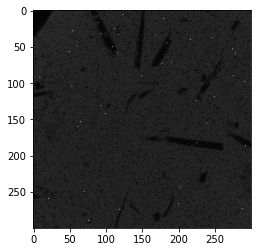

In [288]:
noise_test_dataset = []
for img in X_test:
  noisy_image = util.random_noise(img, seed=0, mode= 's&p', **kwargs)
  noise_test_dataset.append(noisy_image)

noise_test_dataset = np.array(noise_test_dataset)  

plt.imshow(noise_test_dataset[0], cmap = 'gray') 

Construção e Treino Autoencoder

In [289]:
autoencoder = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (2,2), strides = (2,2), padding = 'same', activation = 'relu', input_shape = (300, 300, 1)),
    tf.keras.layers.Conv2D(8, (3,3), strides = (2,2), padding = 'same', activation = 'relu'),

    tf.keras.layers.Conv2D(8, (3,3), strides = (1,1), padding = 'same', activation = 'relu' ),

    tf.keras.layers.Conv2DTranspose(16, (2,2), strides = (2,2), padding = 'same', activation = 'relu'),
    tf.keras.layers.Conv2DTranspose(1, (3,3), strides = (2,2), padding = 'same', activation = 'relu')
])

In [290]:
autoencoder.compile(loss=tf.keras.losses.MeanAbsolutePercentageError(), optimizer=tf.keras.optimizers.Adam(lr=0.0001), metrics = 'acc' )
autoencoder.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 150, 150, 16)      80        
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 75, 75, 8)         1160      
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 75, 75, 8)         584       
_________________________________________________________________
conv2d_transpose_18 (Conv2DT (None, 150, 150, 16)      528       
_________________________________________________________________
conv2d_transpose_19 (Conv2DT (None, 300, 300, 1)       145       
Total params: 2,497
Trainable params: 2,497
Non-trainable params: 0
_________________________________________________________________


In [291]:
autoencoder.fit(noise_dataset.reshape(-1, 300, 300, 1),
               X_train.reshape(-1, 300, 300, 1),
               epochs = 100,
               batch_size = 1,
               validation_data = (noise_test_dataset.reshape(-1, 300, 300, 1), X_test.reshape(-1, 300, 300, 1)))

Epoch 1/100
454/454 [==============================] - 3s 7ms/step - loss: 73.2254 - acc: 2.6921e-07 - val_loss: 68.0252 - val_acc: 5.1020e-07
Epoch 2/100
454/454 [==============================] - 3s 7ms/step - loss: 46.3679 - acc: 2.6921e-07 - val_loss: 52.6849 - val_acc: 5.1020e-07
Epoch 3/100
454/454 [==============================] - 3s 7ms/step - loss: 36.4861 - acc: 2.6921e-07 - val_loss: 39.6699 - val_acc: 5.1020e-07
Epoch 4/100
454/454 [==============================] - 3s 7ms/step - loss: 29.8319 - acc: 2.6921e-07 - val_loss: 32.0012 - val_acc: 5.1020e-07
Epoch 5/100
454/454 [==============================] - 3s 7ms/step - loss: 25.3877 - acc: 2.6921e-07 - val_loss: 27.6010 - val_acc: 5.1020e-07
Epoch 6/100
454/454 [==============================] - 3s 7ms/step - loss: 21.9080 - acc: 2.6921e-07 - val_loss: 24.0299 - val_acc: 5.1020e-07
Epoch 7/100
454/454 [==============================] - 3s 7ms/step - loss: 18.1672 - acc: 2.6921e-07 - val_loss: 19.2052 - val_acc: 5.1020e-07

## performace do treino

In [292]:
evaluation = autoencoder.evaluate(noise_test_dataset.reshape(-1,300,300,1), X_test.reshape(-1,300,300,1))
print("Test Loss -", evaluation[0])
print("Test acc -", evaluation[1])

7/7 [==============================] - 0s 24ms/step - loss: 10.9727 - acc: 5.1020e-07
Test Loss - 10.972672462463379
Test acc - 5.102040745441627e-07


In [293]:
predicted = autoencoder.predict(noise_test_dataset[0].reshape(-1,300, 300,1)).reshape(300,300)

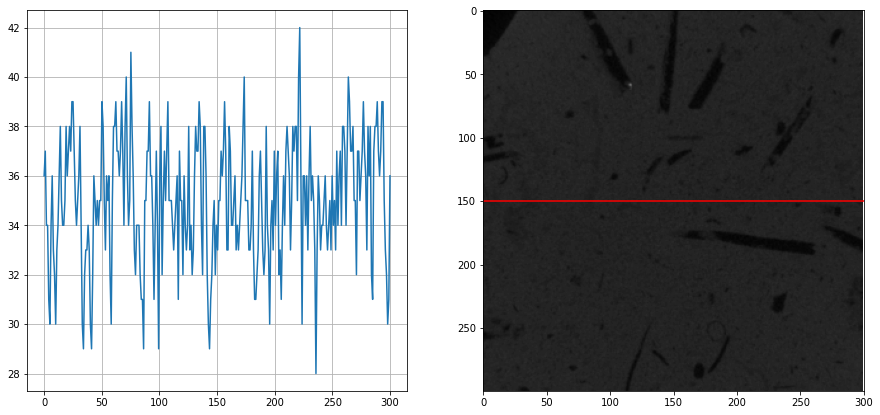

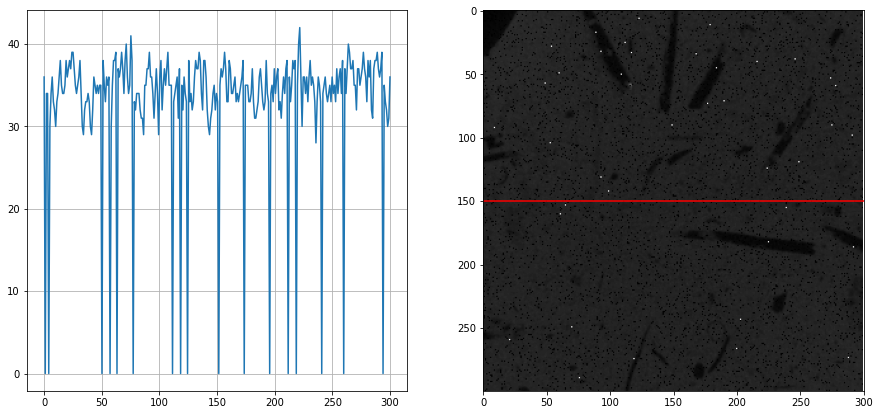

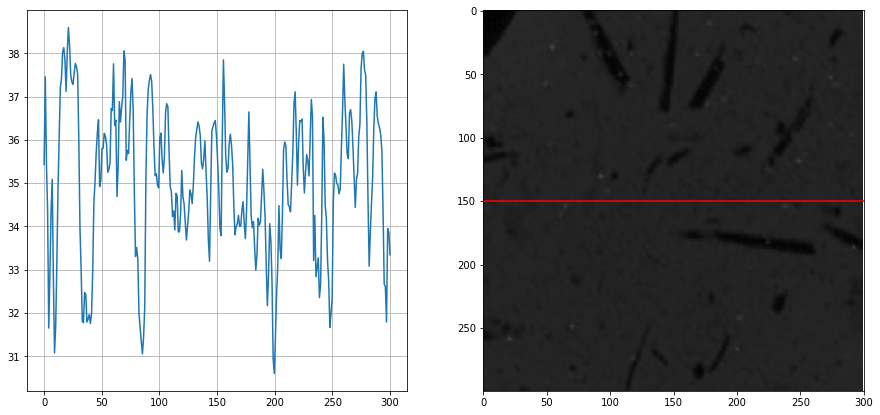

In [294]:
images = [X_test[0],noise_test_dataset[0], predicted]
im_sec_plot(255*images[0], pos=150, bits=8)
im_sec_plot(255*images[1], pos=150, bits=8)
im_sec_plot(255*images[2], pos=150, bits=8)

In [297]:
from matplotlib import image
path_out = 'drive/My Drive/Artigo Segmentação/Imagens/out_tambaba/denoise_DL/'

for i, img in enumerate(im_noise):
  predicted = autoencoder.predict(img.reshape(-1,300, 300,1)).reshape(300,300)
  image.imsave(path_out + f'im_{i}.tiff', predicted, cmap='gray')

In [296]:
im.shape

(650, 300, 300)